In [1]:
%load_ext watermark


In [2]:
import itertools as it

from IPython.display import display
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp
from tqdm import tqdm

from pylib.viz._get_nben_cmap import get_nben_cmap
from pylib.viz._get_nben_hue_norm import get_nben_hue_norm
from pylib.viz._size_fixation_areaplot import size_fixation_areaplot


In [3]:
%watermark -diwmuv -iv


Last updated: 2024-10-17T18:57:39.829841+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.5.0-1025-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

teeplot: 1.1.3
seaborn: 0.13.2
pandas : 2.2.3
numpy  : 2.1.2
polars : 1.9.0

Watermark: 2.4.3



In [4]:
teeplot_subdir = "wse-5050-spatial2d-2048atile-infben-traits"
teeplot_subdir


'wse-5050-spatial2d-2048atile-infben-traits'

## Prep Data


In [5]:
data = [
    {"url": "https://osf.io/qfdsh/download", "max ben muts": np.inf},
    {"url": "https://osf.io/cu9r6/download", "max ben muts": 1},
    # {"url": "https://osf.io/ngdqw/download", "max ben muts": 2},
    # {"url": "https://osf.io/mb5x8/download", "max ben muts": 3},
    # {"url": "https://osf.io/g2ake/download", "max ben muts": 4},
    # {"url": "https://osf.io/3mgcr/download", "max ben muts": 5},
]
dfs = []
for item in tqdm(data):
    df = pd.read_parquet(item["url"])
    df["available beneficial mutations"] = item["max ben muts"]
    df = pl.from_pandas(df)
    df = (
        df.with_columns(
            (pl.col("row").cast(pl.UInt64) // pl.col("nRowSubgrid")).alias(
                "rowGroup"
            ),
            (pl.col("col").cast(pl.UInt64) // pl.col("nColSubgrid")).alias(
                "colGroup"
            ),
        )
        .with_columns(
            (
                pl.col("colGroup")
                + (pl.col("colGroup").max() + 1) * pl.col("rowGroup")
            ).alias("group"),
        )
        .with_columns(
            (
                pl.col("trait value").replace_strict(
                    {0: "normomutator", 1: "hypermutator"},
                )
            ).alias("genotype"),
        )
        .with_columns(
            (
                pl.col("nColSubgrid").cast(pl.UInt64)
                * pl.col("nRowSubgrid").cast(pl.UInt64)
                * pl.col("tilePopSize")
            ).alias("population size"),
        )
        .with_columns(
            (pl.col("trait count") / pl.col("tilePopSize")).alias(
                "fixation probability"
            ),
        )
    )
    dfs.append(
        df.group_by(
            [
                "group",
                "genotype",
                "replicate",
                "population size",
                "available beneficial mutations",
            ],
        ).agg(
            pl.col("fixation probability").mean(),
        ),
    )


100%|██████████| 2/2 [00:30<00:00, 15.37s/it]


In [6]:
dfxs = pl.concat(dfs, how="vertical_relaxed").to_pandas()
dfxs["available\nbeneficial mutations"] = (
    dfxs["available beneficial mutations"]
)
dfxs


,group,genotype,replicate,population size,available beneficial mutations,fixation probability,available\nbeneficial mutations
0,510152.0,normomutator,7404ad4d-c09c-4d0f-ab9d-812169e347a3,2048,inf,0.0,inf
1,225406.0,normomutator,7404ad4d-c09c-4d0f-ab9d-812169e347a3,2048,inf,0.0,inf
2,320231.0,normomutator,7404ad4d-c09c-4d0f-ab9d-812169e347a3,2048,inf,0.0,inf
3,380809.0,normomutator,7404ad4d-c09c-4d0f-ab9d-812169e347a3,2048,inf,0.0,inf
4,471119.0,normomutator,7404ad4d-c09c-4d0f-ab9d-812169e347a3,2048,inf,0.0,inf
...,...,...,...,...,...,...,...
2395063,58090.0,normomutator,a16c8e7c-dfa7-49a1-b411-95297c6ec090,2048,1.0,0.0,1.0
2395064,186699.0,normomutator,a16c8e7c-dfa7-49a1-b411-95297c6ec090,2048,1.0,0.0,1.0
2395065,83863.0,normomutator,a16c8e7c-dfa7-49a1-b411-95297c6ec090,2048,1.0,0.0,1.0
2395066,172295.0,normomutator,a16c8e7c-dfa7-49a1-b411-95297c6ec090,2048,1.0,1.0,1.0


In [7]:
apn = int(dfxs["population size"].min())  # agents per node
apn


0

## Size Fixation Area Plots


/home/runner/work/hypermutator-dynamics/hypermutator-dynamics/binder/pylib/viz/_size_fixation_areaplot.py:23: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.relplot(


teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+errorbar=sd+hue=genotype+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+errorbar=sd+hue=genotype+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.png


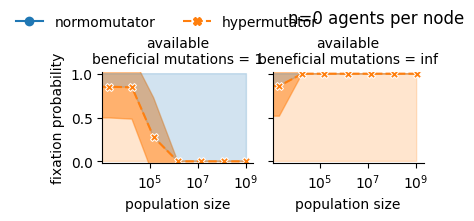

/home/runner/work/hypermutator-dynamics/hypermutator-dynamics/binder/pylib/viz/_size_fixation_areaplot.py:23: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.relplot(


teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+errorbar=se+hue=genotype+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+errorbar=se+hue=genotype+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.png


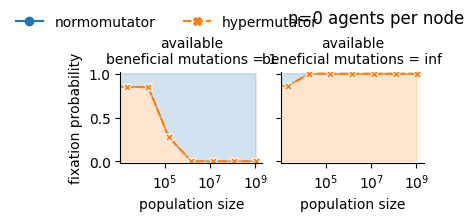

/home/runner/work/hypermutator-dynamics/hypermutator-dynamics/binder/pylib/viz/_size_fixation_areaplot.py:23: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.relplot(


teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+errorbar=ci+hue=genotype+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+errorbar=ci+hue=genotype+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.png


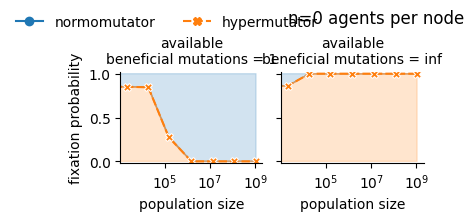

/home/runner/work/hypermutator-dynamics/hypermutator-dynamics/binder/pylib/viz/_size_fixation_areaplot.py:23: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.relplot(


teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+hue=genotype+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+hue=genotype+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.png


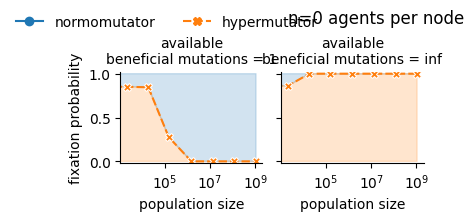

In [8]:
for errorbar in "sd", "se", "ci", None:
    tp.tee(
        size_fixation_areaplot,
        fixprobs_df=dfxs,
        x="population size",
        y="fixation probability",
        hue="genotype",
        hue_order=["normomutator", "hypermutator"],
        col="available\nbeneficial mutations",
        style="genotype",
        style_order=["normomutator", "hypermutator"],
        errorbar=errorbar,
        height=2,
        markers=True,
        teeplot_outexclude="post",
        teeplot_subdir=teeplot_subdir,
        teeplot_postprocess=f"""
teed.figure.suptitle("n={apn} agents per node", x=0.63, y=1.06)
teed.set_titles(col_template="{{col_var}} = {{col_name:.0f}}")
sns.move_legend(
    teed,
    "lower center",
    bbox_to_anchor=(0.25, 0.9),
    frameon=False,
    ncol=2,
    title=None,
)
""",
    )


/home/runner/work/hypermutator-dynamics/hypermutator-dynamics/binder/pylib/viz/_size_fixation_areaplot.py:23: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.relplot(


teeplots/wse-5050-spatial2d-2048atile-infben-traits/errorbar=sd+hue=genotype+num-abm=(1.0,)+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/errorbar=sd+hue=genotype+num-abm=(1.0,)+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.png


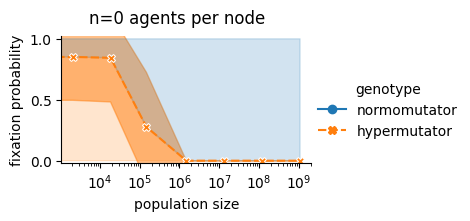

/home/runner/work/hypermutator-dynamics/hypermutator-dynamics/binder/pylib/viz/_size_fixation_areaplot.py:23: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.relplot(


teeplots/wse-5050-spatial2d-2048atile-infben-traits/errorbar=se+hue=genotype+num-abm=(1.0,)+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/errorbar=se+hue=genotype+num-abm=(1.0,)+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.png


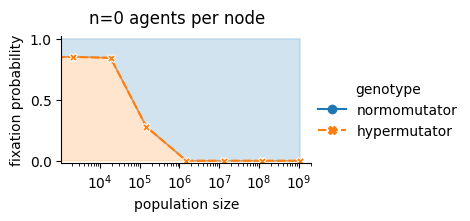

/home/runner/work/hypermutator-dynamics/hypermutator-dynamics/binder/pylib/viz/_size_fixation_areaplot.py:23: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.relplot(


teeplots/wse-5050-spatial2d-2048atile-infben-traits/errorbar=ci+hue=genotype+num-abm=(1.0,)+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/errorbar=ci+hue=genotype+num-abm=(1.0,)+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.png


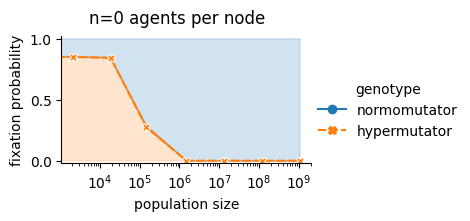

/home/runner/work/hypermutator-dynamics/hypermutator-dynamics/binder/pylib/viz/_size_fixation_areaplot.py:23: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.relplot(


teeplots/wse-5050-spatial2d-2048atile-infben-traits/hue=genotype+num-abm=(1.0,)+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/hue=genotype+num-abm=(1.0,)+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.png


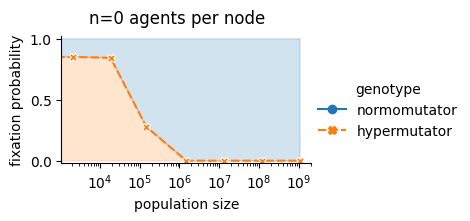

/home/runner/work/hypermutator-dynamics/hypermutator-dynamics/binder/pylib/viz/_size_fixation_areaplot.py:23: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.relplot(


teeplots/wse-5050-spatial2d-2048atile-infben-traits/errorbar=sd+hue=genotype+num-abm=(inf,)+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/errorbar=sd+hue=genotype+num-abm=(inf,)+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.png


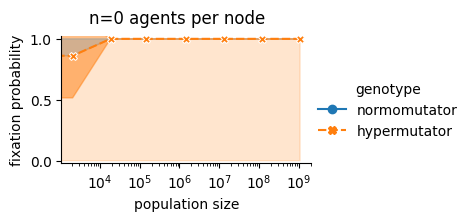

/home/runner/work/hypermutator-dynamics/hypermutator-dynamics/binder/pylib/viz/_size_fixation_areaplot.py:23: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.relplot(


teeplots/wse-5050-spatial2d-2048atile-infben-traits/errorbar=se+hue=genotype+num-abm=(inf,)+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/errorbar=se+hue=genotype+num-abm=(inf,)+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.png


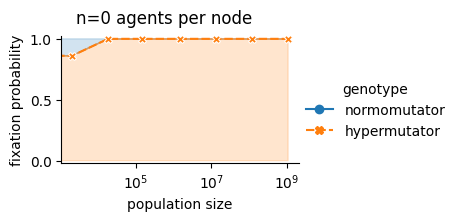

/home/runner/work/hypermutator-dynamics/hypermutator-dynamics/binder/pylib/viz/_size_fixation_areaplot.py:23: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.relplot(


teeplots/wse-5050-spatial2d-2048atile-infben-traits/errorbar=ci+hue=genotype+num-abm=(inf,)+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/errorbar=ci+hue=genotype+num-abm=(inf,)+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.png


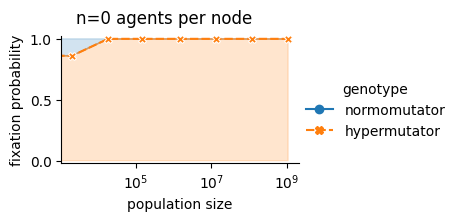

/home/runner/work/hypermutator-dynamics/hypermutator-dynamics/binder/pylib/viz/_size_fixation_areaplot.py:23: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.relplot(


teeplots/wse-5050-spatial2d-2048atile-infben-traits/hue=genotype+num-abm=(inf,)+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/hue=genotype+num-abm=(inf,)+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.png


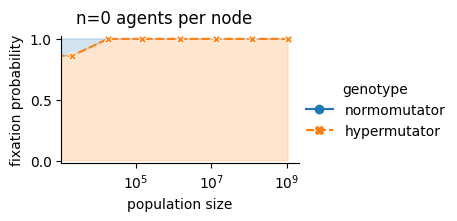

In [9]:
for (num_abm, fixprobs_df), errorbar in it.product(
    dfxs.groupby(["available beneficial mutations"]),
    ("sd", "se", "ci", None),
):
    tp.tee(
        size_fixation_areaplot,
        fixprobs_df=fixprobs_df,
        x="population size",
        y="fixation probability",
        col=None,
        hue="genotype",
        hue_order=["normomutator", "hypermutator"],
        style="genotype",
        style_order=["normomutator", "hypermutator"],
        aspect=1.75,
        errorbar=errorbar,
        height=2,
        markers=True,
        teeplot_outattrs={
            "num-abm": num_abm,
        },
        teeplot_outexclude="post",
        teeplot_subdir=teeplot_subdir,
        teeplot_postprocess=f"""
teed.figure.suptitle("n={apn} agents per node", x=0.42, y=1.06)
""",
    )


## Size Fixation Curves


teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+errorbar=sd+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+errorbar=sd+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.png


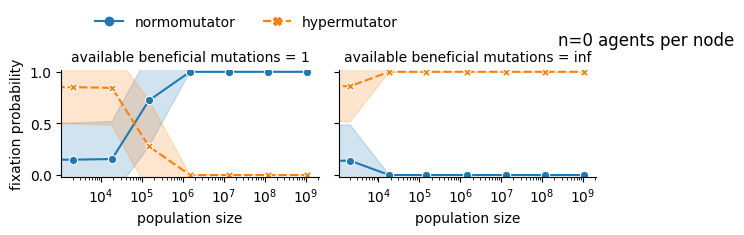

teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+errorbar=se+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+errorbar=se+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.png


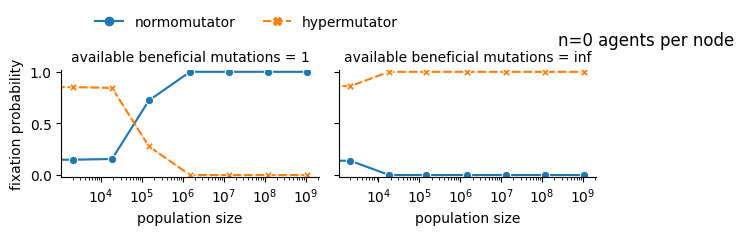

teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+errorbar=ci+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+errorbar=ci+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.png


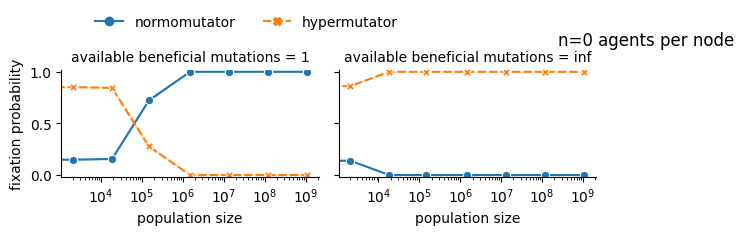

teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+hue=genotype+kind=line+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.png


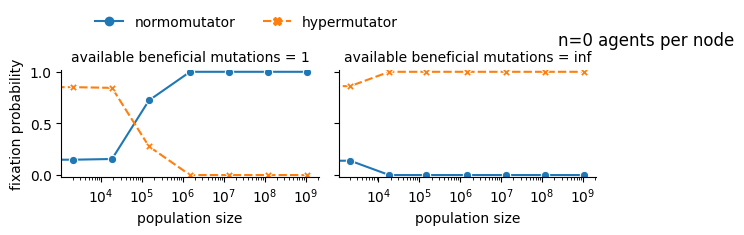

In [10]:
for errorbar in "sd", "se", "ci", None:
    tp.tee(
        sns.relplot,
        data=dfxs,
        x="population size",
        y="fixation probability",
        hue="genotype",
        hue_order=["normomutator", "hypermutator"],
        col="available beneficial mutations",
        style="genotype",
        style_order=["normomutator", "hypermutator"],
        aspect=1.5,
        col_wrap=3,
        errorbar=errorbar,
        height=2,
        kind="line",
        markers=True,
        seed=1,
        teeplot_outexclude="post",
        teeplot_subdir=teeplot_subdir,
        teeplot_postprocess=f"""
teed.set(xscale="log", ylim=(-0.02, 1.02))
teed.figure.suptitle("n={apn} agents per node", x=0.63, y=1.02)
teed.set_titles(col_template="{{col_var}} = {{col_name:.0f}}")
sns.move_legend(
    teed,
    "lower center",
    bbox_to_anchor=(0.25, 0.97),
    frameon=False,
    ncol=2,
    title=None,
)
""",
    )


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1405: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1405: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


teeplots/wse-5050-spatial2d-2048atile-infben-traits/errorbar=sd+hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/errorbar=sd+hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.png


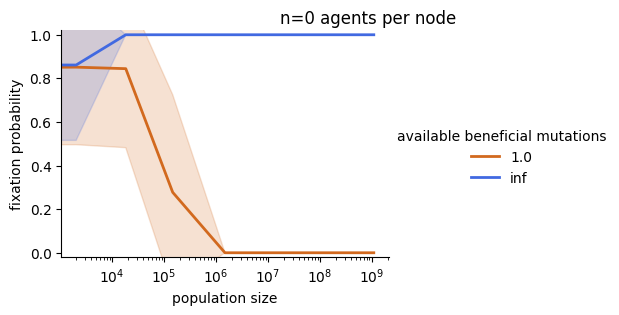

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1405: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1405: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


teeplots/wse-5050-spatial2d-2048atile-infben-traits/errorbar=se+hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/errorbar=se+hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.png


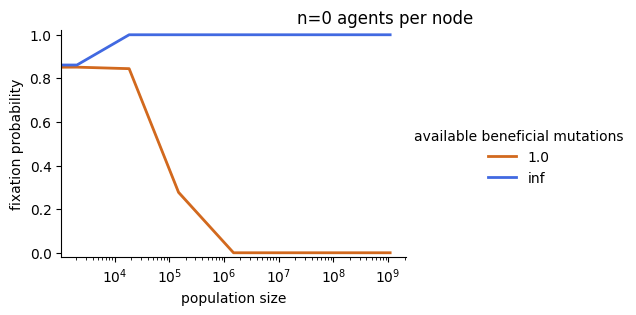

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1405: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1405: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


teeplots/wse-5050-spatial2d-2048atile-infben-traits/errorbar=ci+hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/errorbar=ci+hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.png


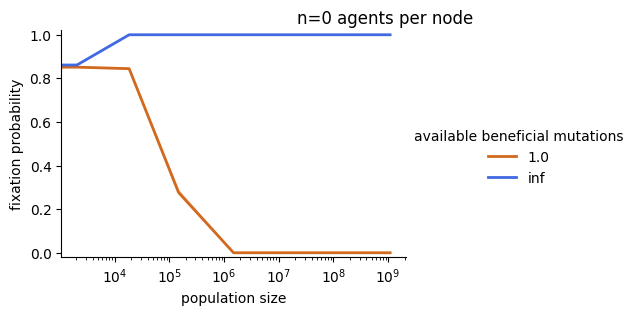

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1405: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1405: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


teeplots/wse-5050-spatial2d-2048atile-infben-traits/hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/hue=available-beneficial-mutations+kind=line+viz=relplot+x=population-size+y=fixation-probability+ext=.png


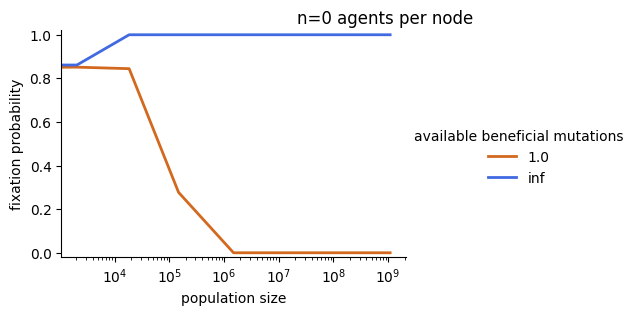

In [11]:
for errorbar in "sd", "se", "ci", None:
    tp.tee(
        sns.relplot,
        data=dfxs[dfxs["genotype"] == "hypermutator"],
        x="population size",
        y="fixation probability",
        hue="available beneficial mutations",
        aspect=1.5,
        height=3,
        kind="line",
        errorbar=errorbar,
        linewidth=2,
        markers=True,
        palette=get_nben_cmap(),
        hue_norm=get_nben_hue_norm(),
        seed=1,
        teeplot_outexclude="post",
        teeplot_postprocess=f"""
teed.set(xscale="log", ylim=(-0.02, 1.02))
teed.figure.suptitle("n={apn} agents per node", x=0.63, y=1.02)
teed.set_titles(col_template='{{col_var}} = {{col_name:.0f}}')
""",
        teeplot_subdir=teeplot_subdir,
    )


## Quality Check: Number Replicates Available


In [12]:
categories = (
    pl.DataFrame(dfxs)
    .group_by(
        "population size",
    )
    .first()["population size"]
    .sort()
    .cast(pl.String)
    .to_list()
)
categories


['0',
 '2048',
 '18432',
 '147456',
 '1492992',
 '13436928',
 '120932352',
 '1088391168']

In [13]:
dfy = pl.DataFrame(dfxs).with_columns(
    pl.col("population size")
    .cast(pl.String)
    .cast(pl.Enum(categories))
    .alias("population size cat"),
)
display(dfy.describe()), display(dfy.head()), display(dfy.tail());


statistic,group,genotype,replicate,population size,available beneficial mutations,fixation probability,available beneficial mutations,population size cat
str,f64,str,str,f64,f64,f64,f64,str
"""count""",2.395056e6,"""2395068""","""2395068""",2.395068e6,2.395068e6,2.395068e6,2.395068e6,"""2395068"""
"""null_count""",12.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""0"""
"""mean""",244979.556526,null,null,16376.940372,inf,0.5,inf,null
"""std""",156807.841702,null,null,2.4864e6,NaN,0.5,NaN,null
"""min""",0.0,"""hypermutator""","""00f14f53-19e5-46dc-856e-0d6ad1…",0.0,1.0,0.0,1.0,null
"""25%""",105943.0,null,null,2048.0,1.0,0.0,1.0,null
"""50%""",232059.0,null,null,2048.0,inf,1.0,inf,null
"""75%""",381749.0,null,null,2048.0,inf,1.0,inf,null
"""max""",531440.0,"""normomutator""","""ffd12655-def2-421a-a0c8-73ba1c…",1.0884e9,inf,1.0,inf,null


group,genotype,replicate,population size,available beneficial mutations,fixation probability,available beneficial mutations,population size cat
f64,str,str,u64,f64,f64,f64,enum
510152.0,"""normomutator""","""7404ad4d-c09c-4d0f-ab9d-812169…",2048,inf,0.0,inf,"""2048"""
225406.0,"""normomutator""","""7404ad4d-c09c-4d0f-ab9d-812169…",2048,inf,0.0,inf,"""2048"""
320231.0,"""normomutator""","""7404ad4d-c09c-4d0f-ab9d-812169…",2048,inf,0.0,inf,"""2048"""
380809.0,"""normomutator""","""7404ad4d-c09c-4d0f-ab9d-812169…",2048,inf,0.0,inf,"""2048"""
471119.0,"""normomutator""","""7404ad4d-c09c-4d0f-ab9d-812169…",2048,inf,0.0,inf,"""2048"""


group,genotype,replicate,population size,available beneficial mutations,fixation probability,available beneficial mutations,population size cat
f64,str,str,u64,f64,f64,f64,enum
58090.0,"""normomutator""","""a16c8e7c-dfa7-49a1-b411-95297c…",2048,1.0,0.0,1.0,"""2048"""
186699.0,"""normomutator""","""a16c8e7c-dfa7-49a1-b411-95297c…",2048,1.0,0.0,1.0,"""2048"""
83863.0,"""normomutator""","""a16c8e7c-dfa7-49a1-b411-95297c…",2048,1.0,0.0,1.0,"""2048"""
172295.0,"""normomutator""","""a16c8e7c-dfa7-49a1-b411-95297c…",2048,1.0,1.0,1.0,"""2048"""
232130.0,"""hypermutator""","""a16c8e7c-dfa7-49a1-b411-95297c…",2048,1.0,1.0,1.0,"""2048"""


teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+hue=genotype+kind=hist+multiple=dodge+viz=displot+x=population-size-cat+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+hue=genotype+kind=hist+multiple=dodge+viz=displot+x=population-size-cat+ext=.png


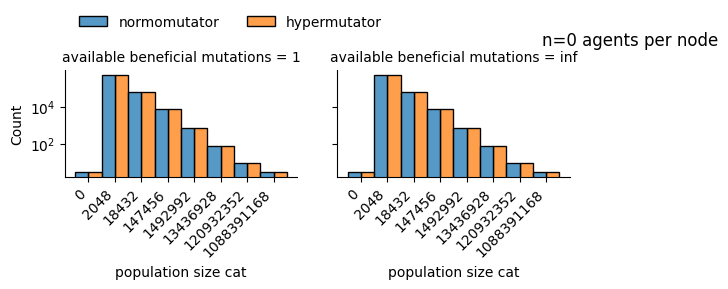

In [14]:
tp.tee(
    sns.displot,
    data=dfy.to_pandas(),
    x="population size cat",
    hue="genotype",
    hue_order=["normomutator", "hypermutator"],
    col="available beneficial mutations",
    aspect=1.5,
    col_wrap=3,
    height=2,
    kind="hist",
    multiple="dodge",
    teeplot_outexclude="post",
    teeplot_postprocess=f"""
teed.set(yscale='log')
teed.figure.suptitle("n={apn} agents per node", x=0.63, y=1.02)
teed.set_titles(col_template='{{col_var}} = {{col_name:.0f}}')
for ax in teed.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")
sns.move_legend(
    teed, "lower center",
    bbox_to_anchor=(0.25, 0.97),
    frameon=False,
    ncol=2,
    title=None,
)
""",
    teeplot_subdir=teeplot_subdir,
)


## Quality Check: Has Reached Fixation?


In [15]:
dfxs_ = dfxs[dfxs["genotype"] == "hypermutator"].copy().reset_index(drop=True)


In [16]:
dfxs_["unfixed"] = (dfxs_["fixation probability"] != 1.0) & (
    dfxs_["fixation probability"] > 0.001
)
any_unfixed = dfxs_["unfixed"].any()
any_unfixed


np.False_

teeplots/wse-5050-spatial2d-2048atile-infben-traits/hue=genotype+kind=scatter+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/hue=genotype+kind=scatter+style=genotype+viz=relplot+x=population-size+y=fixation-probability+ext=.png


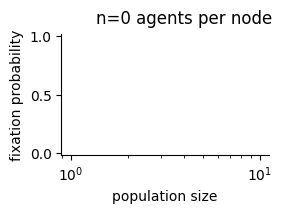

In [17]:
tp.tee(
    sns.relplot,
    data=dfxs_[dfxs_["unfixed"]],
    x="population size",
    y="fixation probability",
    hue="genotype",
    hue_order=["normomutator", "hypermutator"],
    col=[None, "available beneficial mutations"][int(any_unfixed)],
    style="genotype",
    style_order=["normomutator", "hypermutator"],
    aspect=1.5,
    col_wrap=[None, 3][int(any_unfixed)],
    height=2,
    kind="scatter",
    markers=bool(any_unfixed),
    teeplot_outexclude="post",
    teeplot_postprocess=f"""
teed.set(xscale='log', ylim=(-0.02, 1.02))
teed.figure.suptitle("n={apn} agents per node", x=0.63, y=1.02)
teed.set_titles(col_template='{{col_var}} = {{col_name:.0f}}')
try:
    sns.move_legend(
        teed,
        "lower center",
        bbox_to_anchor=(0.25, 0.97),
        frameon=False,
        ncol=2,
        title=None,
    )
except ValueError:
    pass
""",
    teeplot_subdir=teeplot_subdir,
)


teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+hue=unfixed+multiple=fill+viz=displot+x=population-size+ext=.pdf
teeplots/wse-5050-spatial2d-2048atile-infben-traits/col=available-beneficial-mutations+hue=unfixed+multiple=fill+viz=displot+x=population-size+ext=.png


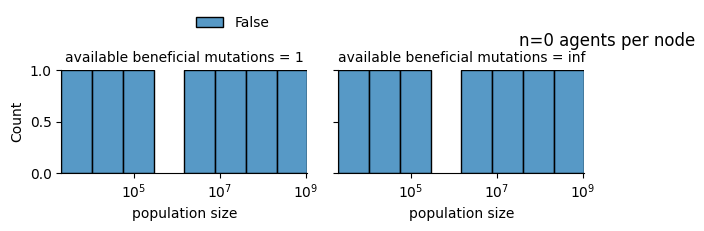

In [18]:
tp.tee(
    sns.displot,
    data=dfxs_.reset_index(drop=True),
    x="population size",
    hue="unfixed",
    col="available beneficial mutations",
    col_wrap=3,
    aspect=1.5,
    height=2,
    multiple="fill",
    bins=dfxs_["population size"].nunique(),
    log_scale=(True, False),
    teeplot_outexclude="post",
    teeplot_postprocess=f"""
teed.figure.suptitle("n={apn} agents per node", x=0.63, y=1.02)
teed.set_titles(col_template='{{col_var}} = {{col_name:.0f}}')
sns.move_legend(
    teed,
    "lower center",
    bbox_to_anchor=(0.25, 0.97),
    frameon=False,
    ncol=2,
    title=None,
)
""",
    teeplot_subdir=teeplot_subdir,
)
